# Customer Churn Analysis

**Project Description**

*Client*: Marketing department of "Metanprom" bank. The bank is experiencing an increased customer churn, which poses a threat to the bank's existence.

*Objective*: Identify homogeneous and highly accurate segments of churned customers, on which interventions should be focused to improve the bank's performance.

*Data Description*:
The dataset contains data about customers of "Metanprom" bank. The bank is located in Yaroslavl and the regional cities: Rostov Veliky and Rybinsk.

Columns:

- `userid` — user identifier,
- `score` — credit score,
- `City` — city,
- `Gender` — gender,
- `Age` — age,
- `equity` — equity score,
- `Balance` — account balance,
- `Products` — number of products used by the customer,
- `CreditCard` — whether the customer has a credit card,
- `last_activity` — active customer indicator,
- `estimated_salary` — customer's estimated salary,
- `Churn` — churn status (whether the customer has churned or not).

*Contents*:
1. Data Loading and Preprocessing
   - Check the correctness of column names and rename them if needed.
   - Data encoding.
   - Check data types and convert them if necessary.
   - Handle missing values.
   - Handle duplicates.
2. Exploratory Data Analysis. Explore correlations and customer profiles.
3. Identify features that influence churn. Draw conclusions.
4. Identify segments that are most prone to churn. Prioritize them.
5. Hypothesis Testing:
   1. Hypothesis on the difference in income between churned and retained customers.
   2. Hypothesis on the difference in churn rate based on the number of products used.


## Data Loading and Preprocessing

### Data Loading

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime
import math as mth
import seaborn as sns

In [2]:
# чтение файла bank_scrooge.csv с данными и сохранение его в переменную 
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)

In [3]:
#выведем первые строки
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


### Handling Missing Values and Data Type Conversion

The first step is to modify column names and bring them into the correct format.

In [4]:
df.rename(columns = {'USERID':'user_id', 
                     'EST_SALARY':'salary'}, 
          inplace = True )

Let's examine missing values and data types:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


There is an incorrect data type in the "age" column, which should be changed to integer. We will remove the missing values in this column since there are only a few (26) and replacing them with other data is not feasible.

In [6]:
# Удаляем все NaN значения
df.dropna(subset=['age'], inplace=True)

# Преобразуем столбец 'age' в тип int
df['age'] = df['age'].astype(int)



We also notice that there are missing values in the "balance" column. It's possible that these missing values represent zero balances, so let's check if there are any customers with zero balances.

In [7]:
df.query('balance == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
3900,179831,730.0,Ярославль,М,18,0,0.0,2,1,1,64548.33,0
6757,148456,813.0,Ярославль,М,20,2,0.0,2,1,0,23876.51,0


Unfortunately, the theory is not confirmed as there are customers with zero balances in the database. It's likely that the missing values appeared due to a different reason. Let's explore the missing values in the "balance" column using alternative methods.

In [8]:
new_df = df.query('balance.isna()')

for column in ['city', 'gender', 'equity', 'products','credit_card', 'churn']:
    print(column)
    print(round(new_df[column].value_counts(normalize=True),2))
    print()    


city
Ярославль    0.64
Рыбинск      0.26
Ростов       0.10
Name: city, dtype: float64

gender
М    0.56
Ж    0.44
Name: gender, dtype: float64

equity
0    0.95
1    0.05
3    0.00
Name: equity, dtype: float64

products
1    0.85
2    0.14
3    0.01
0    0.00
Name: products, dtype: float64

credit_card
1    0.82
0    0.18
Name: credit_card, dtype: float64

churn
0    0.99
1    0.01
Name: churn, dtype: float64



As we can see, missing values are more common among customers from Yaroslavl, but this is not an argument since there are simply more customers from Yaroslavl in general. Gender does not affect the presence of missing values.

However, we can note that among customers with missing values in the "balance" column, most of them have 1 product, and it is often a credit card. Additionally, around 80% of them are churned customers.

In my opinion, there are too many missing values to simply remove them, so let's leave them as they are. Furthermore, there is no clear dependency to impute the missing values.

### Duplicates handling

Let's check for obvious duplicates.

In [9]:
df.duplicated().sum()

0



There are no exact duplicates. Let's check if there are any duplicates in the user IDs.

In [10]:
df['user_id'].duplicated().sum()

50



We found 50 such users. Let's remove them since all IDs should be unique.

In [11]:
df.drop_duplicates(subset='user_id', keep='first', inplace=True)


Now let's check for duplicates in the "salary" column.

In [12]:
df['salary'].duplicated().sum()

3



We found 3 duplicates. Let's examine them.

In [13]:
duplicates = df[df['salary'].duplicated(keep=False)]
print(duplicates)


      user_id  score       city gender  age  equity    balance  products  \
513    120675  832.0    Рыбинск      Ж   37       2  430220.82         2   
884    214629  772.0  Ярославль      М   53       2  335295.37         2   
2442   152240  861.0     Ростов      Ж   60       3  599546.80         2   
4642   133759  831.0  Ярославль      М   50       5  560145.71         2   
6050   202056  979.0    Рыбинск      Ж   30       2  820572.71         3   
8376   217828  947.0  Ярославль      М   30       5  393215.11         1   

      credit_card  last_activity     salary  churn  
513             1              1   49742.87      0  
884             1              1  176348.18      0  
2442            0              1   49742.87      0  
4642            1              1  108250.17      0  
6050            1              0  108250.17      0  
8376            1              0  176348.18      0  




The remaining data is completely different, so it's likely just a coincidence in the numbers. We'll leave them as they are.

Next, let's check the accuracy of the data in the "products" and "credit_card" columns. If we find any rows where "products" is listed as 0 but "credit_card" is listed as 1, it indicates an error.

In [14]:
df.query('(products == 0) & (credit_card == 1)')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn




There are no such rows.

### Outlier Handling


Now let's examine the data for the presence of abnormal values.

In [15]:
# посмотрим на минимальные и максимальные значения по каждому столбцу 
df.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,salary,churn
count,9924.000000,9924.000000,9924.000000,9924.000000,7.664000e+03,9924.000000,9924.000000,9924.000000,9.924000e+03,9924.000000
mean,171737.158706,848.731358,42.728839,2.634522,8.282063e+05,1.871624,0.679968,0.523378,1.478802e+05,0.183293
std,33697.419981,65.396890,12.176452,1.979371,1.984122e+06,0.793151,0.466512,0.499478,1.393583e+05,0.386926
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142725.000000,802.000000,33.000000,0.000000,2.955266e+05,1.000000,0.000000,0.000000,7.525218e+04,0.000000
50%,172643.000000,853.000000,40.000000,3.000000,5.249277e+05,2.000000,1.000000,1.000000,1.197154e+05,0.000000
75%,201159.250000,900.000000,51.000000,4.000000,9.807537e+05,2.000000,1.000000,1.000000,1.746669e+05,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000




- The "score" column ranges from 642 (minimum) to 1000 (maximum).
- The "age" column ranges from 18 to 86, which seems plausible.
- The "equity" column ranges from 0 to 9. We can assume that higher scores indicate a more favorable client status.
- The "balance" column ranges from 0 to 120 million. Let's examine the distribution of these data.
- The "products" column ranges from 0 to 5, which seems plausible.
- The "salary" column ranges from 2500 to 1.4 million. Let's examine the distribution of these data.

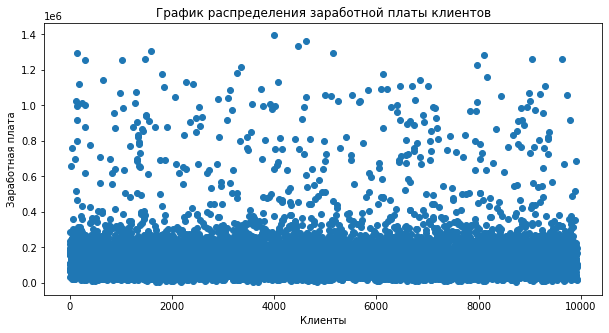

In [16]:
x_values = pd.Series(range(0,len(df['salary'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, df['salary'])
plt.xlabel('Клиенты')
plt.ylabel('Заработная плата')
plt.title('График распределения заработной платы клиентов');



The data is distributed normally. Low salaries are more common than high salaries, just like in real life.


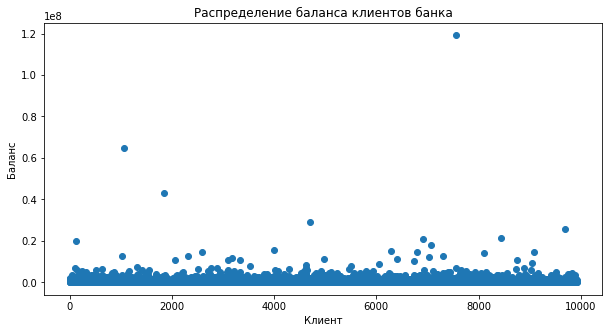

In [17]:
x_values = pd.Series(range(0,len(df['balance'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, df['balance'])
plt.xlabel('Клиент')
plt.ylabel('Баланс')
plt.title('Распределение баланса клиентов банка');


All the graphs and tables indicate that the only column with anomalous values is the "balance" column. However, these data are likely accurate; they are simply rare occurrences. To facilitate analysis, we will remove the most noticeable outliers.

In [18]:
df['balance'].describe()

count    7.664000e+03
mean     8.282063e+05
std      1.984122e+06
min      0.000000e+00
25%      2.955266e+05
50%      5.249277e+05
75%      9.807537e+05
max      1.191136e+08
Name: balance, dtype: float64

In [19]:
#исключим выбросы
df['balance'] = df[(df['balance'] >= 0) & (df['balance'] <= 800000)]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9924 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9924 non-null   int64  
 1   score          9924 non-null   float64
 2   city           9924 non-null   object 
 3   gender         9924 non-null   object 
 4   age            9924 non-null   int64  
 5   equity         9924 non-null   int64  
 6   balance        5165 non-null   object 
 7   products       9924 non-null   int64  
 8   credit_card    9924 non-null   int64  
 9   last_activity  9924 non-null   int64  
 10  salary         9924 non-null   float64
 11  churn          9924 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1007.9+ KB




**Conclusion**

During the data preprocessing stage, we changed the data type in the "age" column, removed duplicates, and handled missing values where possible. We also applied data encoding to the "age" and "city" columns. Lastly, we removed outliers from the dataset.

## Exploratory Data Analysis

### Analysis of All Bank Customers

Let's start by examining the overall profile of the bank's customers.

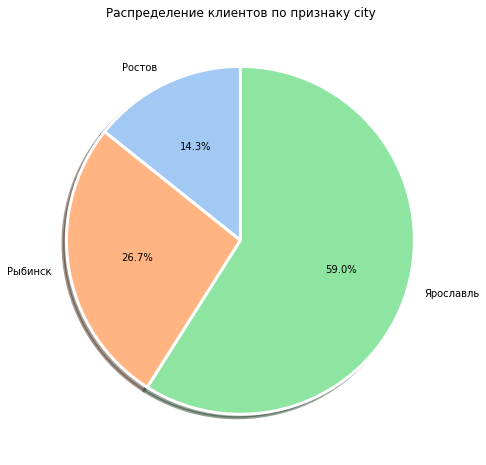

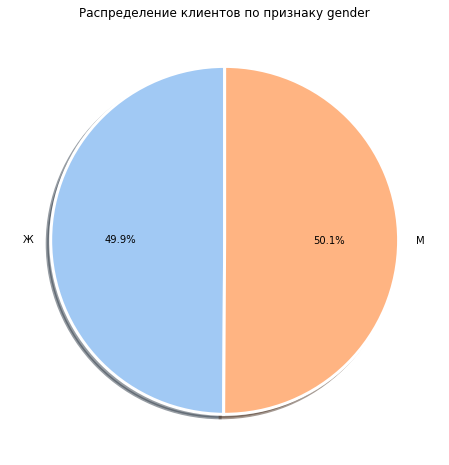

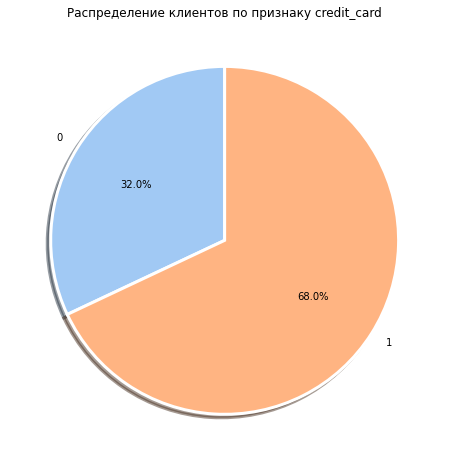

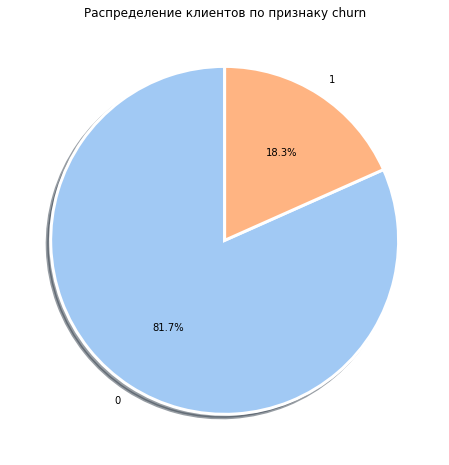

In [21]:
for column in ['city', 'gender','credit_card','churn']:
    new_df = df.groupby(column).agg({'user_id': 'count'})
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    colors = sns.color_palette('pastel')[0:5]
    ax1.pie(new_df['user_id'], labels=new_df.index, colors=colors, autopct='%1.1f%%', 
    shadow=True, startangle=90, wedgeprops={'linewidth': 3, 'edgecolor': 'white'})
    ax1.set_title(f'Распределение клиентов по признаку {column}')
    plt.show()

Let's define the "typical" characteristics of customers at "Metanprom" bank:

59% of customers are from Yaroslavl city.
Gender is almost evenly split, but males are slightly more prevalent.
68% of customers have a credit card.
82% of customers are non-churned, while 18% represent the churned customer percentage.

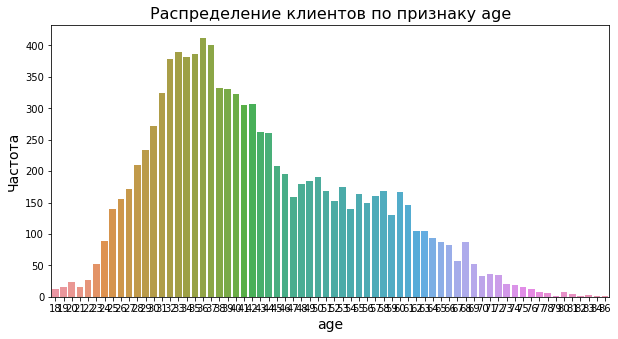

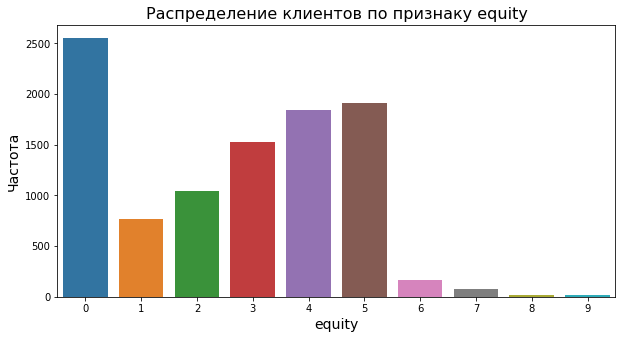

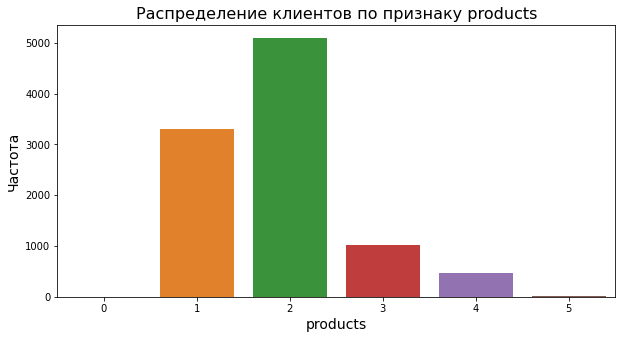

In [22]:
for column in ['age', 'equity', 'products']:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=column)
    plt.title(f'Распределение клиентов по признаку {column}', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

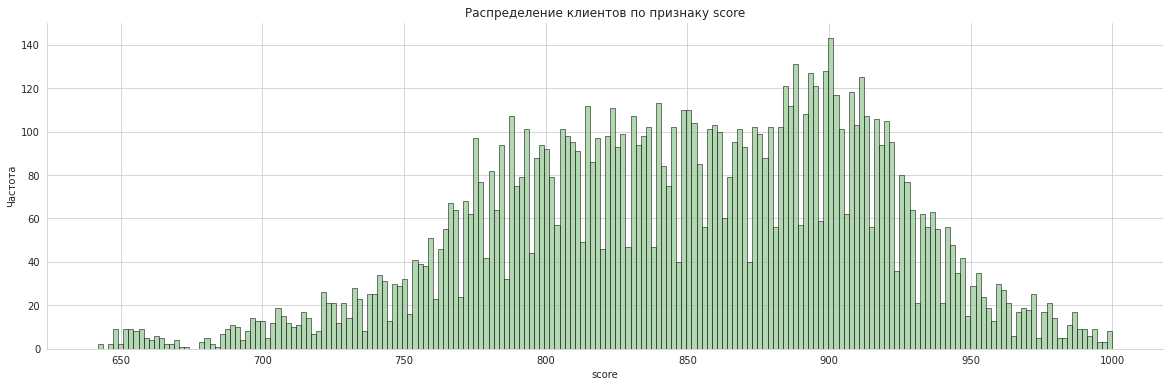

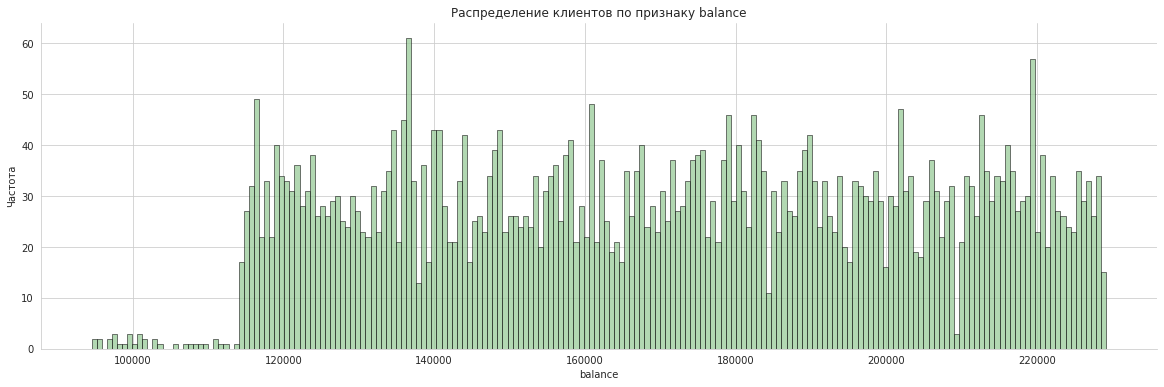

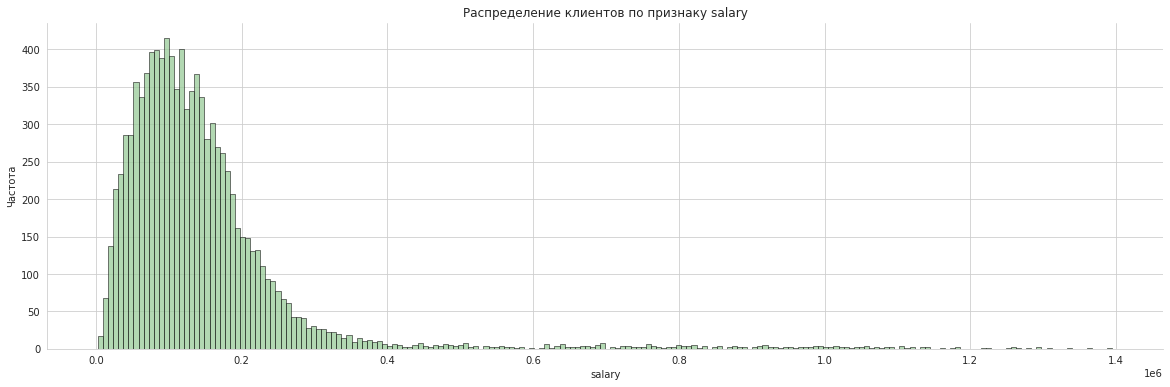

In [23]:
light_green = (0.6, 0.8, 0.6)  

for column in ['score', 'balance', 'salary']:
    plt.figure(figsize=(20, 6))
    sns.set_style("whitegrid")
    sns.histplot(data=df, x=column, bins=200, color=light_green, edgecolor='black')
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    sns.despine()
    plt.show();

Conclusions from the graphs:

The most common age range is between 32 and 37.
Ratings of 0, 4, and 5 are the most common property scores.
Customers most frequently have 2 products.
The majority of customers have a score value between 800 and 920.
Balances for customers range from 120,000 to 220,000 rubles.
The average salary for customers is between 70,000 and 180,000 rubles.

### Analysis of Churned Customers

Let's examine the overall churn percentage:

In [24]:
total_churn_percent = round((df['churn'].sum() / len(df)) * 100, 2)
print("Общий процент оттока по всем данным:", total_churn_percent)

Общий процент оттока по всем данным: 18.33


Let's analyze churn rates based on different factors:



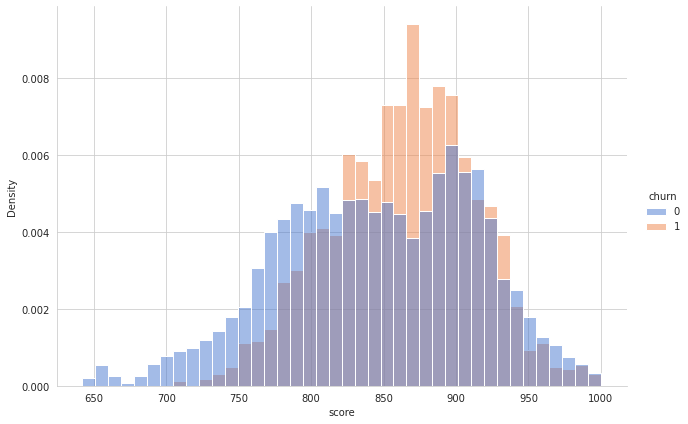

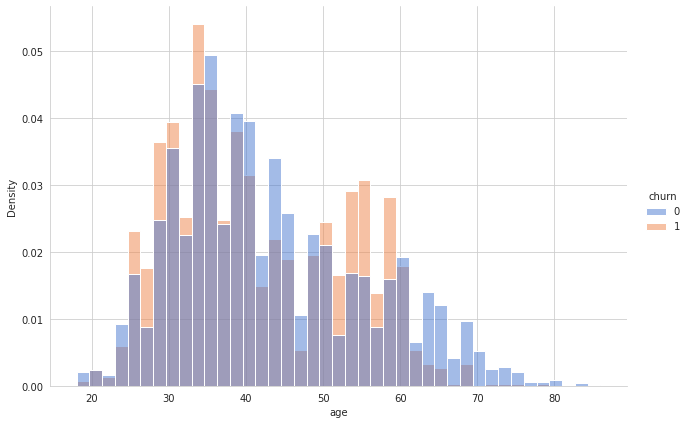

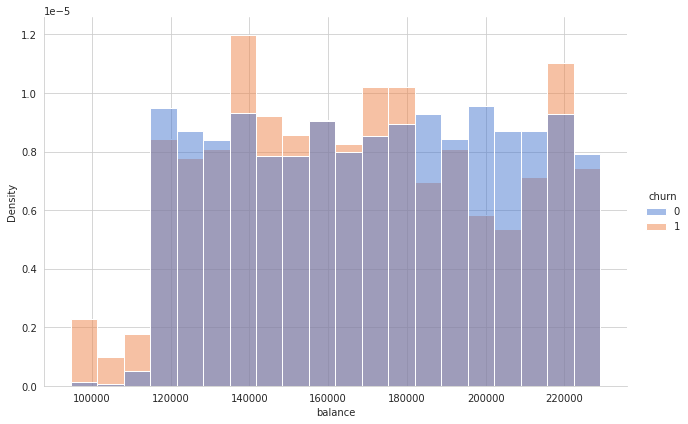

In [25]:
for column in ['score', 'age', 'balance']:
    sns.set_palette("muted")
    sns.displot(df, x=column, hue=df['churn'], stat="density", common_norm=False, height=6, aspect=1.5)
    plt.show();

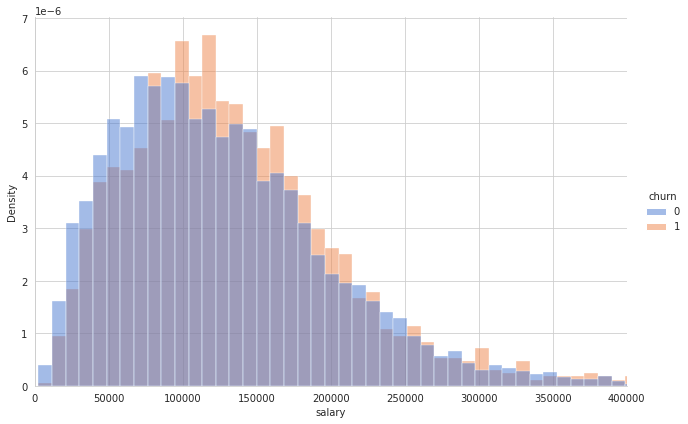

In [26]:
sns.set_palette("muted")
sns.displot(df, x=df['salary'], hue=df['churn'], stat="density", common_norm=False, height=6, aspect=1.5)
plt.xlim(0, 400000)
plt.show();

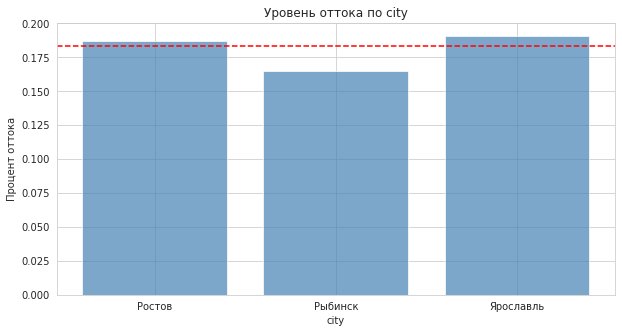

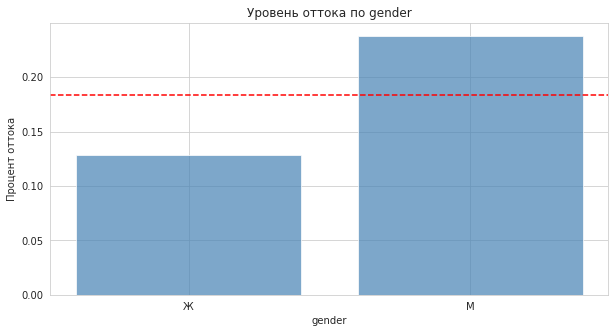

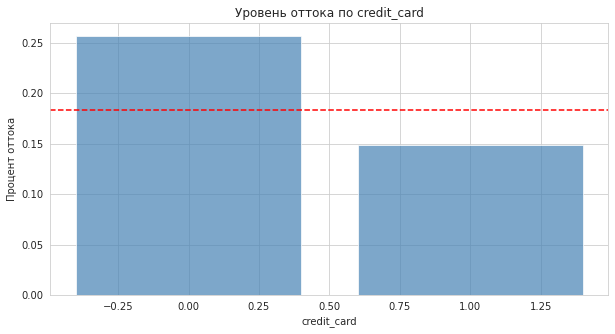

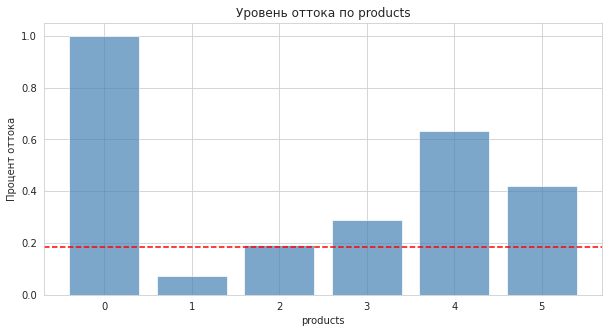

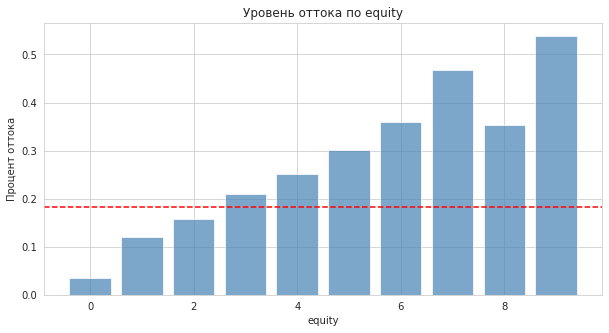

In [27]:
for column in ['city', 'gender', 'credit_card', 'products', 'equity']:
    plt.figure(figsize=(10, 5))
    mean_churn = df.groupby(column)['churn'].mean()
    plt.bar(mean_churn.index, mean_churn.values, color='steelblue', alpha=0.7)
    mean_churn_all = df['churn'].mean()
    plt.axhline(mean_churn_all, linestyle='dashed', color='red', label='Средний отток (все данные)')
    plt.xlabel(f'{column}')
    plt.ylabel('Процент оттока')
    plt.title(f'Уровень оттока по {column}')
    plt.show();

Overall churn percentage across all data: 18.33%.

After analyzing all the indicators, we can identify several characteristics associated with churn:

- Scores ranging from 830 to 950.
- Age groups between 50 and 60, as well as 25-30.
- Male customers.
- Balances between 100,000 and 120,000, and 140,000-180,000.
- Higher churn rates in Yaroslavl.
- Customers without a credit card.
- Customers with 3, 4, or 5 products (excluding 0, as there is only one customer with churn status).
- Equity scores between 3 and 9, especially 6, 7, and 9.
- Salaries between 100,000 and 220,000.

Less prone to churn are customers with the following characteristics:
- Scores between 690 and 820.
- Age groups between 36-45 and 60+.
- Balances between 140,000 and 180,000.
- Salaries ranging from 0 to 90,000.
- Customers residing in Rybinsk.
- Female customers.
- Customers with a credit card.
- Customers with 1 product.
- Equity scores between 0 and 2.

### Correlation Matrix

Let's explore possible correlations and identify which customers are most prone to churn.

To examine the mean and correlations between categorical data and numerical values, let's encode the columns for city and gender. First, we'll duplicate them and encode them:

In [28]:
df['city_code'] = df['city']
df['city_code'] = df['city_code'].map({'Ярославль':0, 'Рыбинск':1, 'Ростов':2})

# Применяем one-hot кодирование с помощью метода pandas.get_dummies()
df = pd.get_dummies(df, columns=['city_code'], prefix='', prefix_sep='')
df = df.rename(columns={'0': 'Ярославль', '1': 'Рыбинск', '2': 'Ростов'})

In [29]:
df['gender_code'] = df['gender']
df['gender_code'] = df['gender_code'].map({'М':1, 'Ж':0})

# Применяем one-hot кодирование с помощью метода pandas.get_dummies()
df = pd.get_dummies(df, columns=['gender_code'], prefix='', prefix_sep='')
df = df.rename(columns={'0': 'Ж', '1': 'М'})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,Ярославль,Рыбинск,Ростов,Ж,М
0,183012,850.0,Рыбинск,Ж,25,1,183012.0,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37,5,NaN,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51,5,NaN,2,0,1,174423.53,1,1,0,0,1,0
4,157978,730.0,Ярославль,М,34,5,157978.0,1,1,0,67353.16,1,1,0,0,0,1


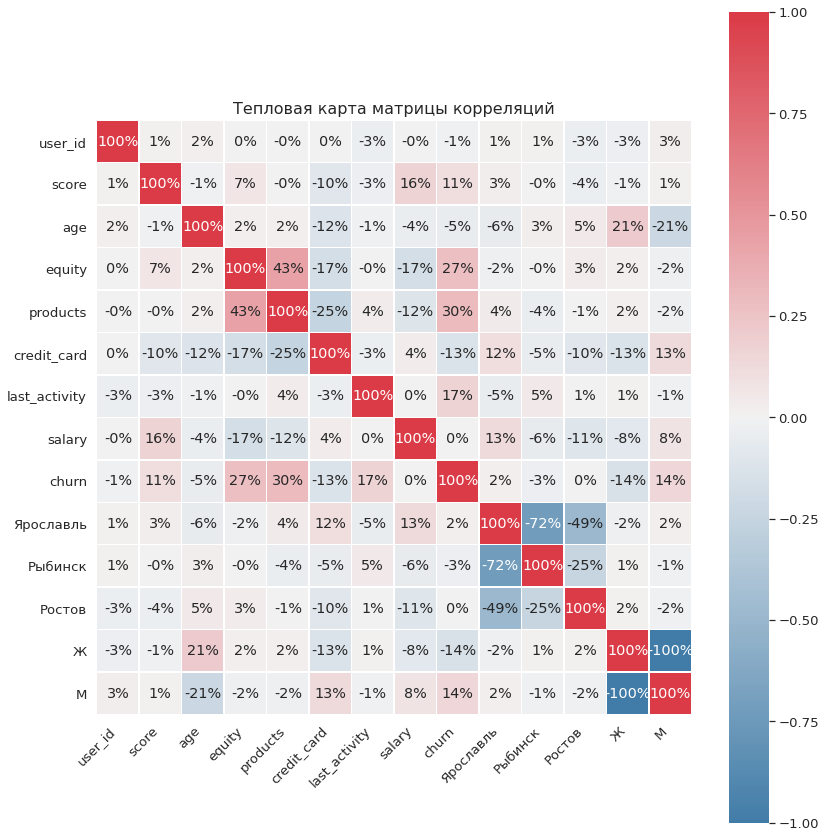

In [30]:
matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.set(font_scale=1.2)  

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(matrix, annot=True, fmt=".0%", cmap=cmap, square=True, cbar=True, linewidths=0.5)
plt.title('Тепловая карта матрицы корреляций', fontsize=16)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  

plt.tight_layout()
plt.show()

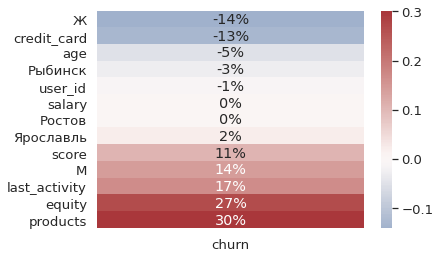

In [31]:
sns.heatmap(
    matrix.loc[:,['churn']].drop('churn').sort_values('churn'), annot=True, 
    fmt=".0%", cmap='vlag', center=0);

There is no strong correlation between the indicators. The highest correlation with churn is observed for the number of products (30%) and the equity score (27%). However, this is not sufficient to conclude a definite dependency. Male customers are slightly more prone to churn than female customers, and Yaroslavl has a higher churn rate compared to other cities, but these dependencies are weak.



### Customer Segmentation

Let's identify the most churn-prone segments.

Highly churn-prone segments, albeit small in size:

In [32]:
filtered_df = df.query("gender == 'М' and products >= 3 and products <= 5")

total_customers = len(filtered_df)
churned_customers = len(filtered_df[filtered_df['churn'] == 1])

percentage_churned =  round((churned_customers / total_customers) * 100, 2)

print(f"Процент отточных клиентов: {percentage_churned}%")

percentage_users = round((len(filtered_df) / len(df)) * 100, 2)
print(f"Процент пользователей в filtered_df от общего датафрейма: {percentage_users}%")
print(f"Количество всего пользователей в сегменте: {total_customers}")
print(f"Количество отточных пользователей в сегменте: {churned_customers}")


Процент отточных клиентов: 50.27%
Процент пользователей в filtered_df от общего датафрейма: 7.54%
Количество всего пользователей в сегменте: 748
Количество отточных пользователей в сегменте: 376


In [33]:
filtered_df = df.query("score >= 830 and score <= 950 and products >= 3 and products <= 5")

total_customers = len(filtered_df)
churned_customers = len(filtered_df[filtered_df['churn'] == 1])

percentage_churned =  round((churned_customers / total_customers) * 100, 2)

print(f"Процент отточных клиентов: {percentage_churned}%")

percentage_users = round((len(filtered_df) / len(df)) * 100, 2)
print(f"Процент пользователей в filtered_df от общего датафрейма: {percentage_users}%")
print(f"Количество всего пользователей в сегменте: {total_customers}")
print(f"Количество отточных пользователей в сегменте: {churned_customers}")




Процент отточных клиентов: 48.12%
Процент пользователей в filtered_df от общего датафрейма: 8.84%
Количество всего пользователей в сегменте: 877
Количество отточных пользователей в сегменте: 422


In [34]:
filtered_df = df.query("salary >= 90000 and salary <= 230000 and products >= 3 and products <= 5")

total_customers = len(filtered_df)
churned_customers = len(filtered_df[filtered_df['churn'] == 1])

percentage_churned =  round((churned_customers / total_customers) * 100, 2)

print(f"Процент отточных клиентов: {percentage_churned}%")

percentage_users = round((len(filtered_df) / len(df)) * 100, 2)
print(f"Процент пользователей в filtered_df от общего датафрейма: {percentage_users}%")
print(f"Количество всего пользователей в сегменте: {total_customers}")
print(f"Количество отточных пользователей в сегменте: {churned_customers}")


Процент отточных клиентов: 45.84%
Процент пользователей в filtered_df от общего датафрейма: 8.11%
Количество всего пользователей в сегменте: 805
Количество отточных пользователей в сегменте: 369


In [35]:
filtered_df = df.query("equity >= 3 and equity <= 9 and products >= 3 and products <= 5")

total_customers = len(filtered_df)
churned_customers = len(filtered_df[filtered_df['churn'] == 1])

percentage_churned =  round((churned_customers / total_customers) * 100, 2)

print(f"Процент отточных клиентов: {percentage_churned}%")

percentage_users = round((len(filtered_df) / len(df)) * 100, 2)
print(f"Процент пользователей в filtered_df от общего датафрейма: {percentage_users}%")
print(f"Количество всего пользователей в сегменте: {total_customers}")
print(f"Количество отточных пользователей в сегменте: {churned_customers}")



Процент отточных клиентов: 42.82%
Процент пользователей в filtered_df от общего датафрейма: 12.28%
Количество всего пользователей в сегменте: 1219
Количество отточных пользователей в сегменте: 522


Moderately churn-prone segments:

In [36]:
filtered_df = df.query("gender == 'М' and city == 'Ярославль'")

total_customers = len(filtered_df)
churned_customers = len(filtered_df[filtered_df['churn'] == 1])

percentage_churned =  round((churned_customers / total_customers) * 100, 2)

print(f"Процент отточных клиентов: {percentage_churned}%")

percentage_users = round((len(filtered_df) / len(df)) * 100, 2)
print(f"Процент пользователей в filtered_df от общего датафрейма: {percentage_users}%")
print(f"Количество всего пользователей в сегменте: {total_customers}")
print(f"Количество отточных пользователей в сегменте: {churned_customers}")



Процент отточных клиентов: 23.79%
Процент пользователей в filtered_df от общего датафрейма: 30.08%
Количество всего пользователей в сегменте: 2985
Количество отточных пользователей в сегменте: 710


In [37]:
filtered_df = df.query("(balance >= 100000 and balance <= 120000) or (balance >= 140000 and balance <= 180000)")

total_customers = len(filtered_df)
churned_customers = len(filtered_df[filtered_df['churn'] == 1])

percentage_churned =  round((churned_customers / total_customers) * 100, 2)

print(f"Процент отточных клиентов: {percentage_churned}%")

percentage_users = round((len(filtered_df) / len(df)) * 100, 2)
print(f"Процент пользователей в filtered_df от общего датафрейма: {percentage_users}%")
print(f"Количество всего пользователей в сегменте: {total_customers}")
print(f"Количество отточных пользователей в сегменте: {churned_customers}")



Процент отточных клиентов: 19.74%
Процент пользователей в filtered_df от общего датафрейма: 20.68%
Количество всего пользователей в сегменте: 2052
Количество отточных пользователей в сегменте: 405


After a comprehensive data analysis, we can identify several highly churn-prone segments (with churn rates exceeding 43% within the segment):
- Males with 3 to 5 products in the bank (376 individuals).
- All customers with scores ranging from 700 to 950 and with 3 to 5 products in the bank (579 individuals).
- Customers with salaries between 90,000 and 230,000 and with 3 to 5 products in the bank (369 individuals).
- Customers with property scores between 3 and 9 and with 3 to 5 products in the bank (522 individuals).

These are narrow segments but exhibit a high churn rate. Additionally, there are broader segments with churn rates higher than the average:
- Males from Yaroslavl (710 individuals).
- All customers with balances between 100,000 and 120,000, and 140,000-180,000 (405 individuals).

### Conclusion

Overall churn rate across all data: 18.33%.

After analyzing all the indicators, we have identified several churn-related features:
- Scores ranging from 830 to 950.
- Age groups of 50-60 and 25-30.
- Male customers are more likely to churn.
- Balances between 100,000 and 120,000, and 140,000-180,000.
- Higher churn rate in Yaroslavl.
- Customers without a credit card.
- Customers with 3, 4, or 5 products.
- Equity scores ranging from 3 to 9, especially 6, 7, and 9.
- Salaries between 100,000 and 220,000.

More loyal bank customers exhibit the following characteristics:
- Scores between 690 and 820.
- Age groups of 36-45 and 60+.
- Balances between 140,000 and 180,000.
- Salaries between 0 and 90,000.
- Reside in Rybinsk.
- Female customers.
- Have a credit card.
- Have 1 product with the bank.
- Have equity scores between 0 and 2.

Based on the correlation matrix, there is no strong dependency between the indicators. The highest correlations with churn are observed for the number of products (30%) and equity scores (27%). However, this is not sufficient to assert a definite relationship. Male customers are more prone to churn than female customers. Additionally, Yaroslavl exhibits a higher tendency for churn compared to other cities, but the dependency is weak.

**Segments**

After a comprehensive data analysis, several highly churn-prone segments (with churn rates exceeding 43% within the segment) can be identified:
- Males with 3 to 5 products (376 individuals).
- All customers with scores ranging from 700 to 950 and with 3 to 5 products (579 individuals).
- Customers with salaries between 90,000 and 230,000 and with 3 to 5 products (369 individuals).
- Customers with equity scores between 3 and 9 and with 3 to 5 products (522 individuals).

These are narrow segments but exhibit a high churn rate. Additionally, there are broader segments with churn rates higher than the average:
- Males from Yaroslavl (710 individuals).
- All customers with balances between 100,000 and 120,000, and 140,000-180,000 (405 individuals).

## Testing Statistical Hypotheses

1. Hypothesis of income difference between customers who churned and those who stayed.
2. Hypothesis of churn rate difference based on the number of products held by customers.

### The hypothesis of the difference in income between those customers who left and those who stayed

First, let's examine the mean, median, standard deviation, and display the histogram once again.

In [38]:
df.groupby('churn')['salary'].agg(['mean', 'median', 'std'])

,mean,median,std
churn,,,
0,147788.268353,118247.25,142792.184844
1,148289.702221,125395.22,122932.162335


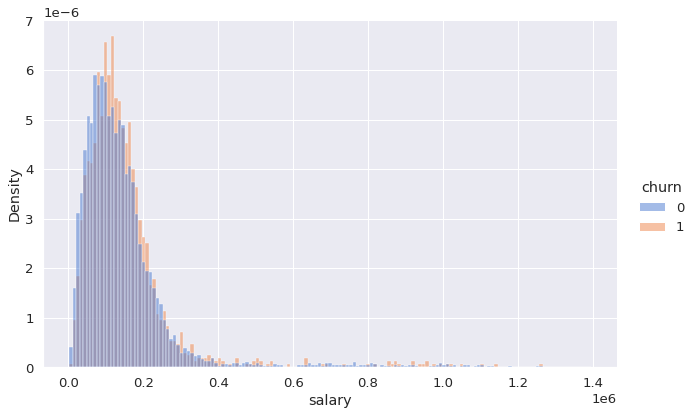

In [39]:
sns.set_palette("muted")
sns.displot(df, x=df['salary'], hue=df['churn'], stat="density", common_norm=False, height=6, aspect=1.5)
plt.show();

We will test the hypotheses using the Mann-Whitney test since the samples have very similar distributions and are independent. The hypotheses are formulated as follows:
 - H0: There is no statistically significant difference in income between the groups.
 - H1: There is a statistically significant difference in income between the groups.

In [40]:
from scipy.stats import mannwhitneyu

alpha = 0.05

churn_clients = df[df['churn'] == 1]['salary']
not_churn_clients = df[df['churn'] == 0]['salary']

statistic, p_value = mannwhitneyu(churn_clients, not_churn_clients)

print(p_value) 

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


0.00023403935398296229
Отвергаем нулевую гипотезу


**Conclusion:**

We failed to reject the null hypothesis, indicating that there is no evidence to suggest a statistically significant difference in income between the samples. Therefore, salary does influence a customer's inclination to leave or stay with the bank.

### Hypothesis of churn rate difference based on the number of products held by customers.

First, let's examine the mean, median, standard deviation, and display the histogram once again.

In [41]:
df.groupby('churn')['products'].agg(['mean', 'median', 'std'])

,mean,median,std
churn,,,
0,1.758421,2,0.713447
1,2.376031,2,0.923592


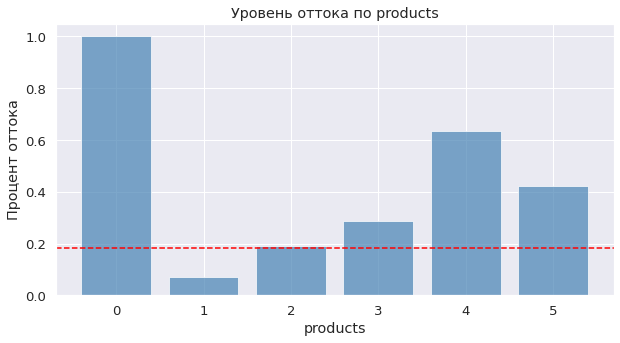

In [42]:
for column in ['products']:
    plt.figure(figsize=(10, 5))
    mean_churn = df.groupby(column)['churn'].mean()
    plt.bar(mean_churn.index, mean_churn.values, color='steelblue', alpha=0.7)
    mean_churn_all = df['churn'].mean()
    plt.axhline(mean_churn_all, linestyle='dashed', color='red', label='Средний отток (все данные)')
    plt.xlabel(f'{column}')
    plt.ylabel('Процент оттока')
    plt.title(f'Уровень оттока по {column}')
    plt.show();

We will apply the Mann-Whitney test since the samples are independent. The hypotheses are formulated as follows:
 - H0: There is no statistically significant difference in the number of products held by customers between the groups.
 - H1: There is a statistically significant difference in the number of products held by customers between the groups.

In [43]:
churn_clients_products = df[df['churn'] == 1]['products']
not_churn_clients_products = df[df['churn'] == 0]['products']

alpha = 0.05

statistic, p_value = mannwhitneyu(churn_clients_products, not_churn_clients_products)

print(p_value) 

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

2.9819452011704528e-161
Отвергаем нулевую гипотезу


Conclusion: We reject the null hypothesis, indicating that the number of products held by a customer does influence churn.

## Recommendations for the marketing department:


Based on the identified segments and their high churn rates, the following recommendations can be proposed to the marketing department of "Metanprom" bank:
1. Strengthen customer retention:
Focus on male customers with 3 to 5 products. Investigate the reasons behind their likelihood to churn and offer personalized services or loyalty programs to retain them. Pay special attention to customers with high scores (830 to 910) and 3 to 5 products. Provide them with individualized offers to strengthen their connection with the bank.

3. Optimize the product portfolio:
Analyze the products and services offered by the bank and identify which ones may be less appealing to customers in the identified segments. Develop tailored service packages and favorable offers for customers with salaries between 100,000 and 220,000 and equity scores between 3 and 9, who have 3 to 5 products. This can help strengthen their loyalty and increase the likelihood of them staying.

4. Enhance the customer experience:
Conduct feedback analysis and assess the level of customer satisfaction within these segments. Identify key issues and reasons for dissatisfaction. Work on resolving them and improving the overall customer experience. For males from Yaroslavl and customers with balances between 100,000 and 120,000, and 140,000-180,000, organize special events, offer additional benefits or discounts to attract their attention and strengthen the relationship with the bank.

5. Competitor analysis:
Study competitors who successfully retain customers in these segments. Learn from their best practices and optimal strategies for customer retention. Analyze their products to identify their strengths and weaknesses.

6. Monitor results:
Establish a system to track and analyze the results of implemented marketing strategies. Regularly evaluate their effectiveness and analyze changes in customer churn within each segment. Conduct a follow-up analysis.

## Presentation

https://drive.google.com/file/d/1pA8AkOgywYUHSsHyzh8lwcZbiWCgTt_X/view?usp=sharing

## Dashboard

https://public.tableau.com/app/profile/snezhana.mozheyko/viz/Book1_16836461083130/Dashboard1?publish=yes